In [44]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
import librosa
import librosa.display

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

In [45]:
df=pd.read_csv("C:/jenre/metadata.csv")

In [46]:
df

,FileName,Class
0,blues.00000.wav,blues
1,blues.00001.wav,blues
2,blues.00002.wav,blues
3,blues.00003.wav,blues
4,blues.00004.wav,blues
...,...,...
994,rock.00095.wav,rock
995,rock.00096.wav,rock
996,rock.00097.wav,rock
997,rock.00098.wav,rock


Class
blues        100
classical    100
country      100
disco        100
hiphop       100
metal        100
pop          100
reggae       100
rock         100
jazz          99
Name: count, dtype: int64


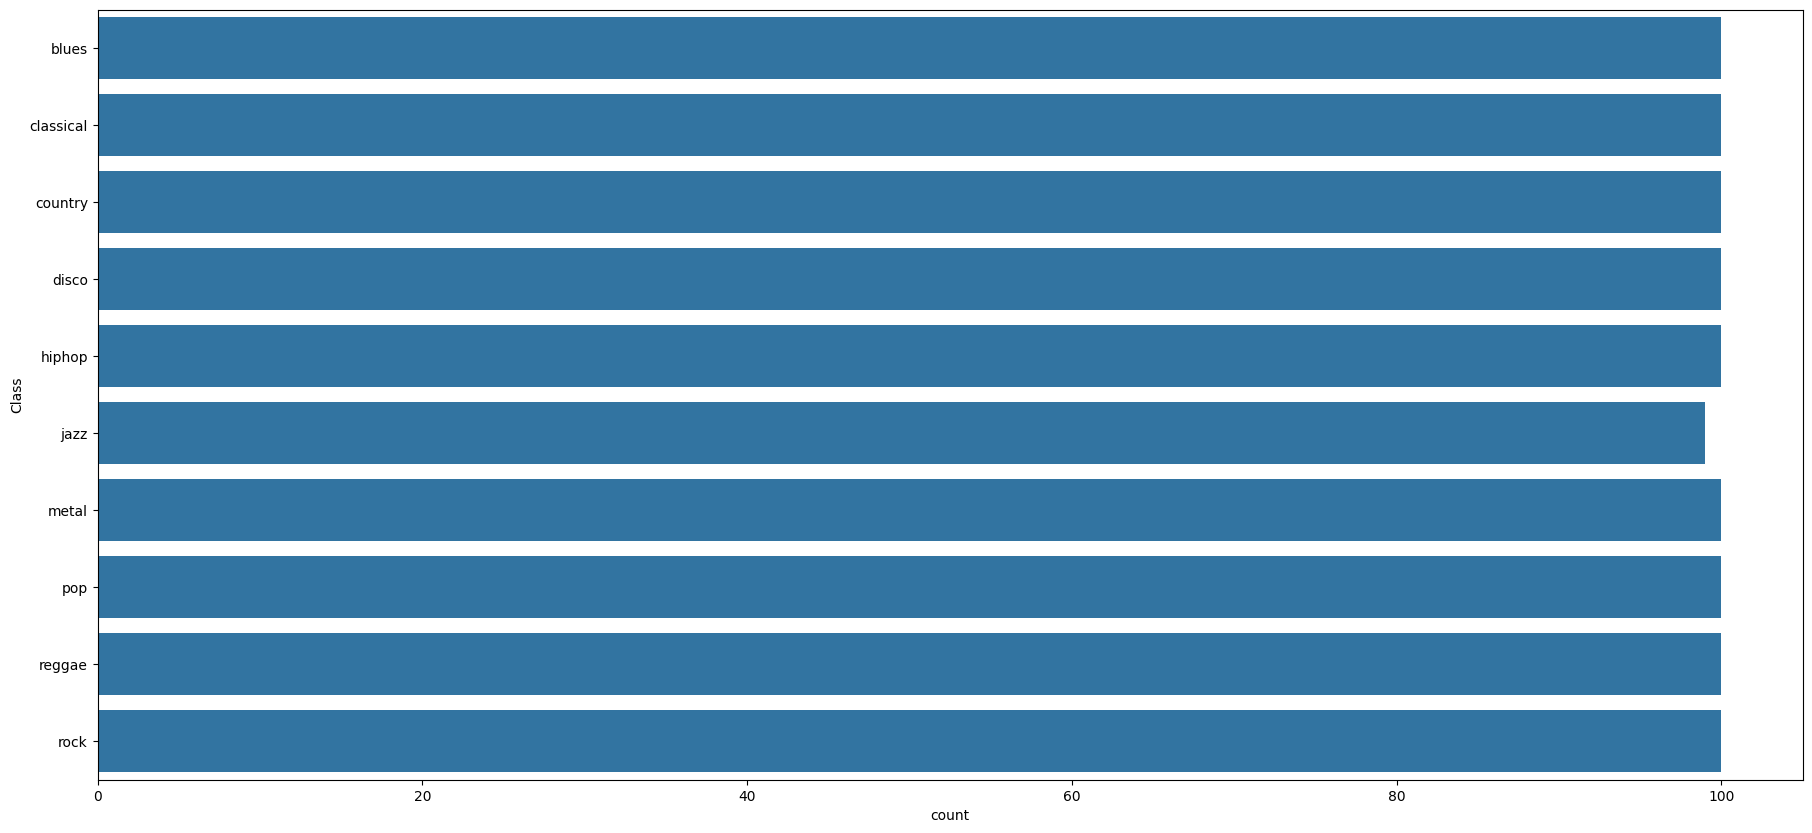

In [47]:
# Visualizing Tag column

print(df['Class'].value_counts())
plt.figure(figsize=(22,10))
sns.countplot(df['Class'])
plt.xticks(rotation=0)

plt.show()

In [48]:
df.set_index('FileName',inplace=True)

for f in df.index:
    rate, signal = wavfile.read('C:/jenre/GTZAN_data/' + f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.Class))
class_dist = df.groupby(['Class'])['length'].mean()

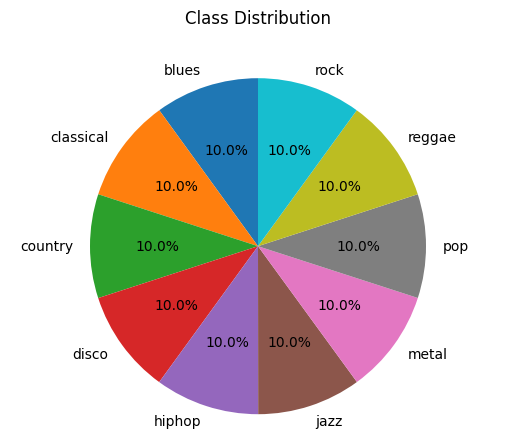

In [49]:
# Volume of each labels

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()
df.reset_index(inplace=True)

In [50]:
# Calculate FFT

def calc_fft(y,sr):
    
    n=len(y)
    freq=np.fft.rfftfreq(n,d=1/sr)
    Y=abs(np.fft.rfft(y)/n)
    return (Y,freq)

In [51]:
# Valuable Info In Sample

def Envelope(y, rate, threshold):
    mask = []
    #we want a rolling window so we create series as it is easy with it
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/4), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
            
    return mask

In [52]:
# Taking One Audio from each class 
# Applying some FE methods

signals = {}
fft = {}
fnames=[]
mfccs = {}


for c in classes:
    wav_file = df[df.Class == c].iloc[0,0]
    fnames.append('C:/jenre/GTZAN/'+wav_file)
    signal, rate = librosa.load('C:/jenre/GTZAN/'+wav_file,sr=44100)
    mask = Envelope(signal, rate, 0.0005) #0.0005 is experimental
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)

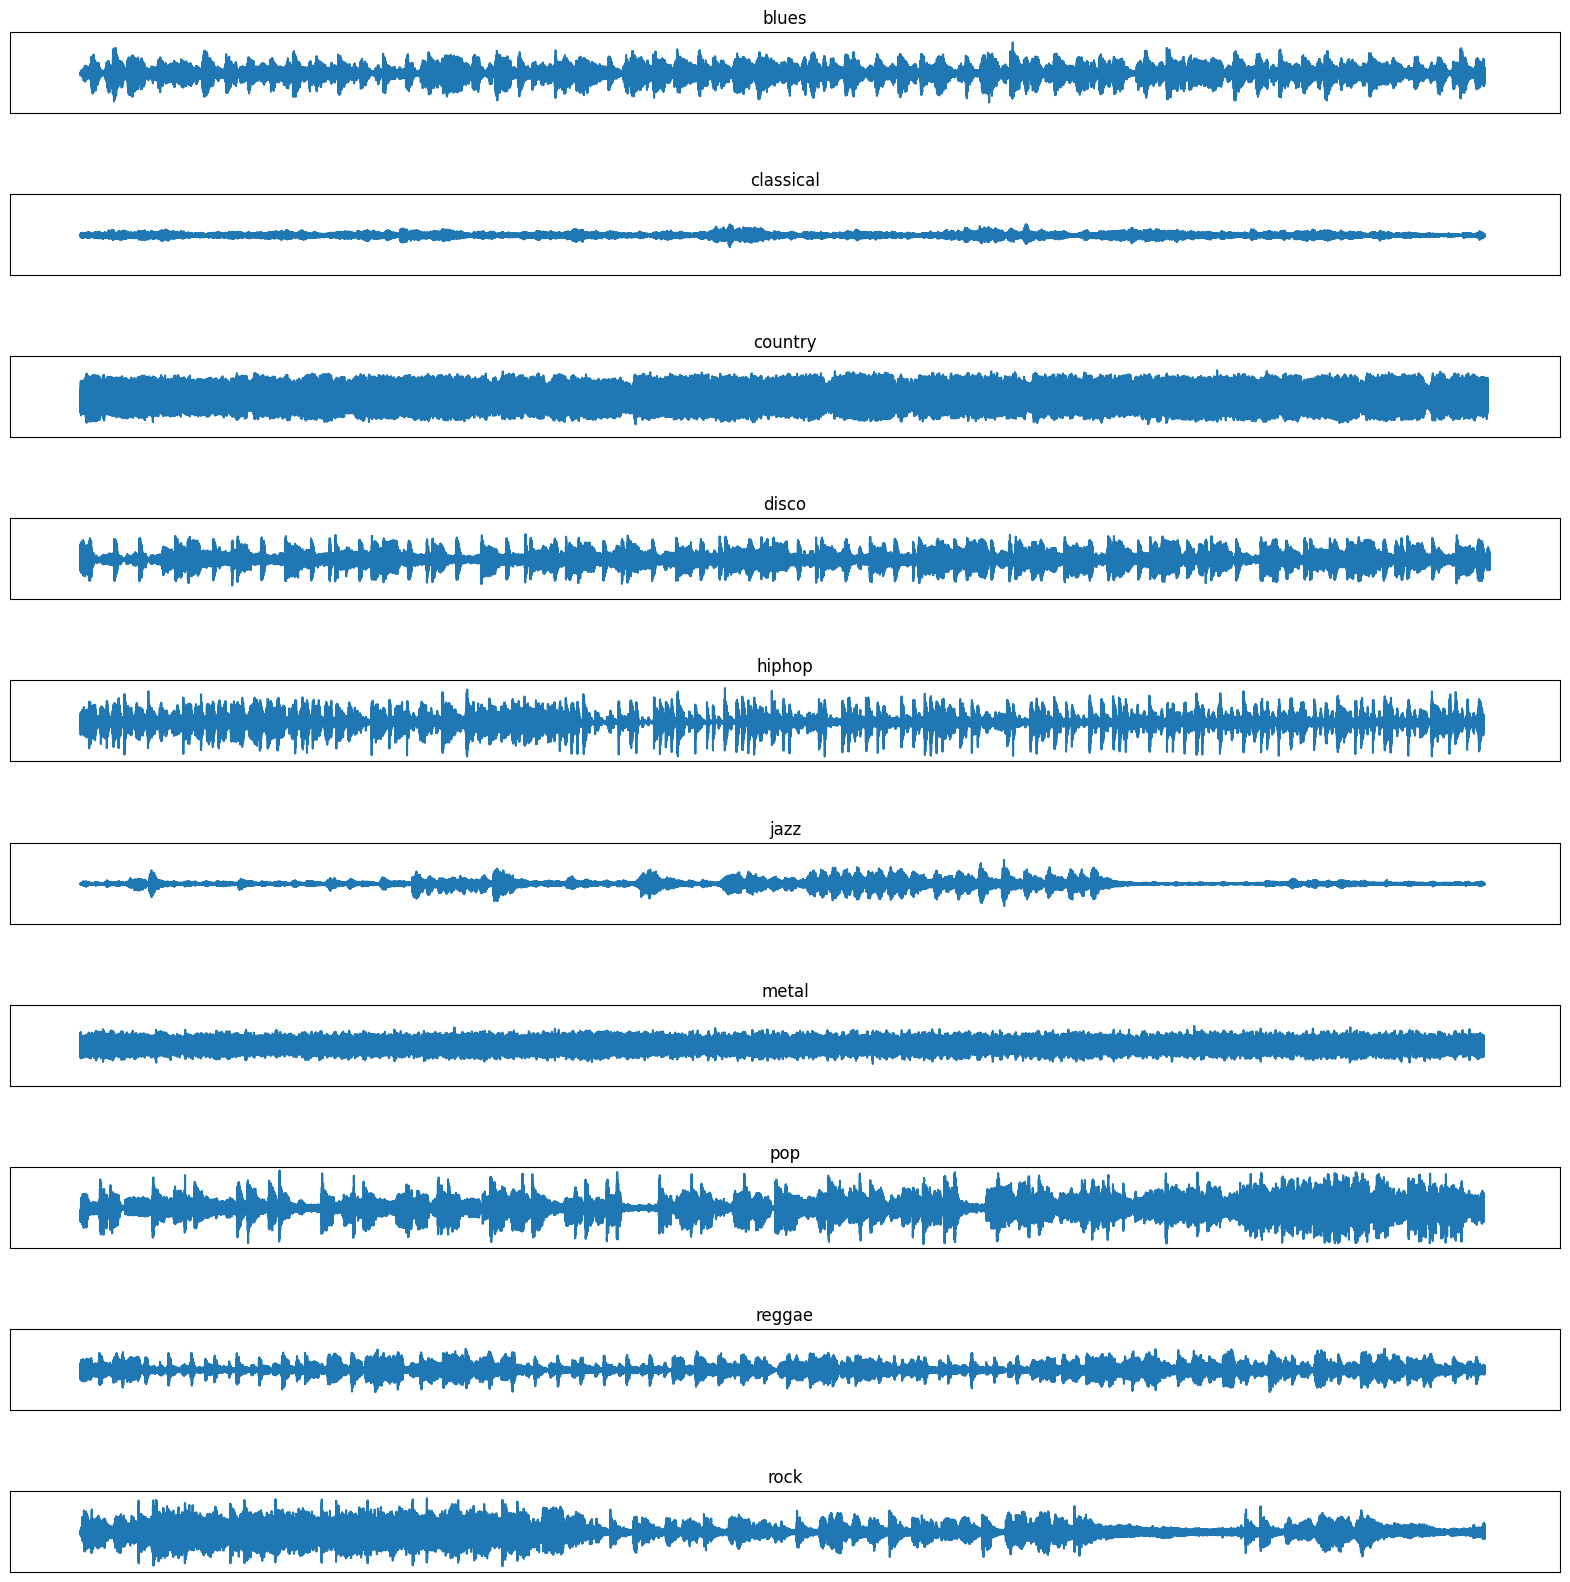

In [53]:
# Plotting Signals

def plot_signals(signals):
    fig, axes = plt.subplots(nrows=10, ncols=1, sharex=True, sharey=True, figsize=(20,20))
    fig.subplots_adjust(hspace=1)
    i = 0
    for x in range(10):
        axes[x].set_title(list(signals.keys())[x])
        axes[x].plot(list(signals.values())[x])
        axes[x].get_xaxis().set_visible(False)
        axes[x].get_yaxis().set_visible(False)
    plt.show()

# plot signals
plot_signals(signals)


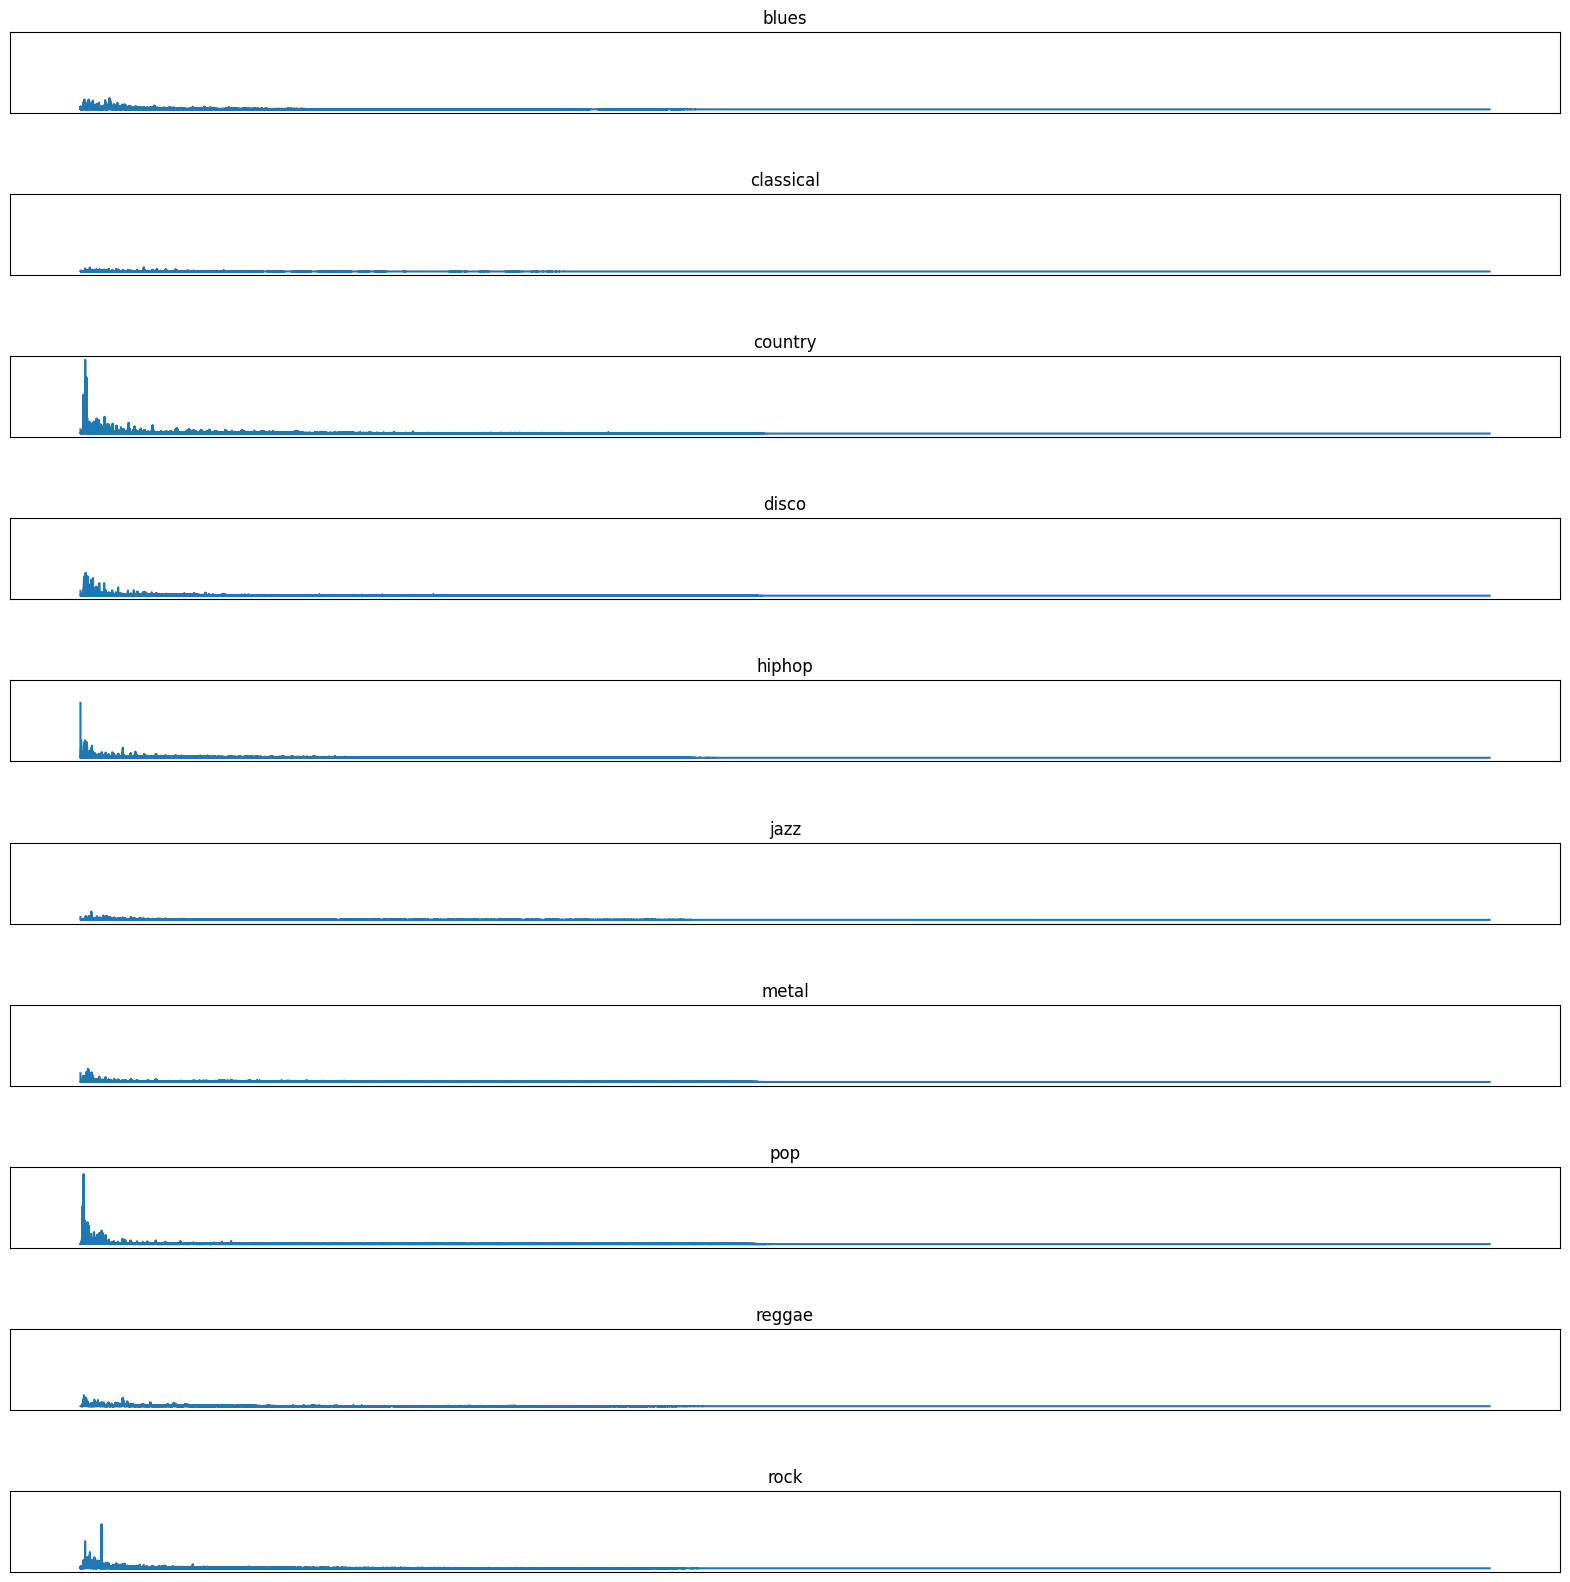

In [54]:
# Plotting ffts

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=10, ncols=1, sharex=True, sharey=True, figsize=(20,20))
    fig.subplots_adjust(hspace=1)
    i = 0
    for x in range(10):
        data = list(fft.values())[x]
        Y, freq = data[0], data[1]
        axes[x].set_title(list(fft.keys())[x])
        axes[x].plot(freq, Y)
        axes[x].get_xaxis().set_visible(False)
        axes[x].get_yaxis().set_visible(False)
    plt.show()

# plot FFT
plot_fft(fft)


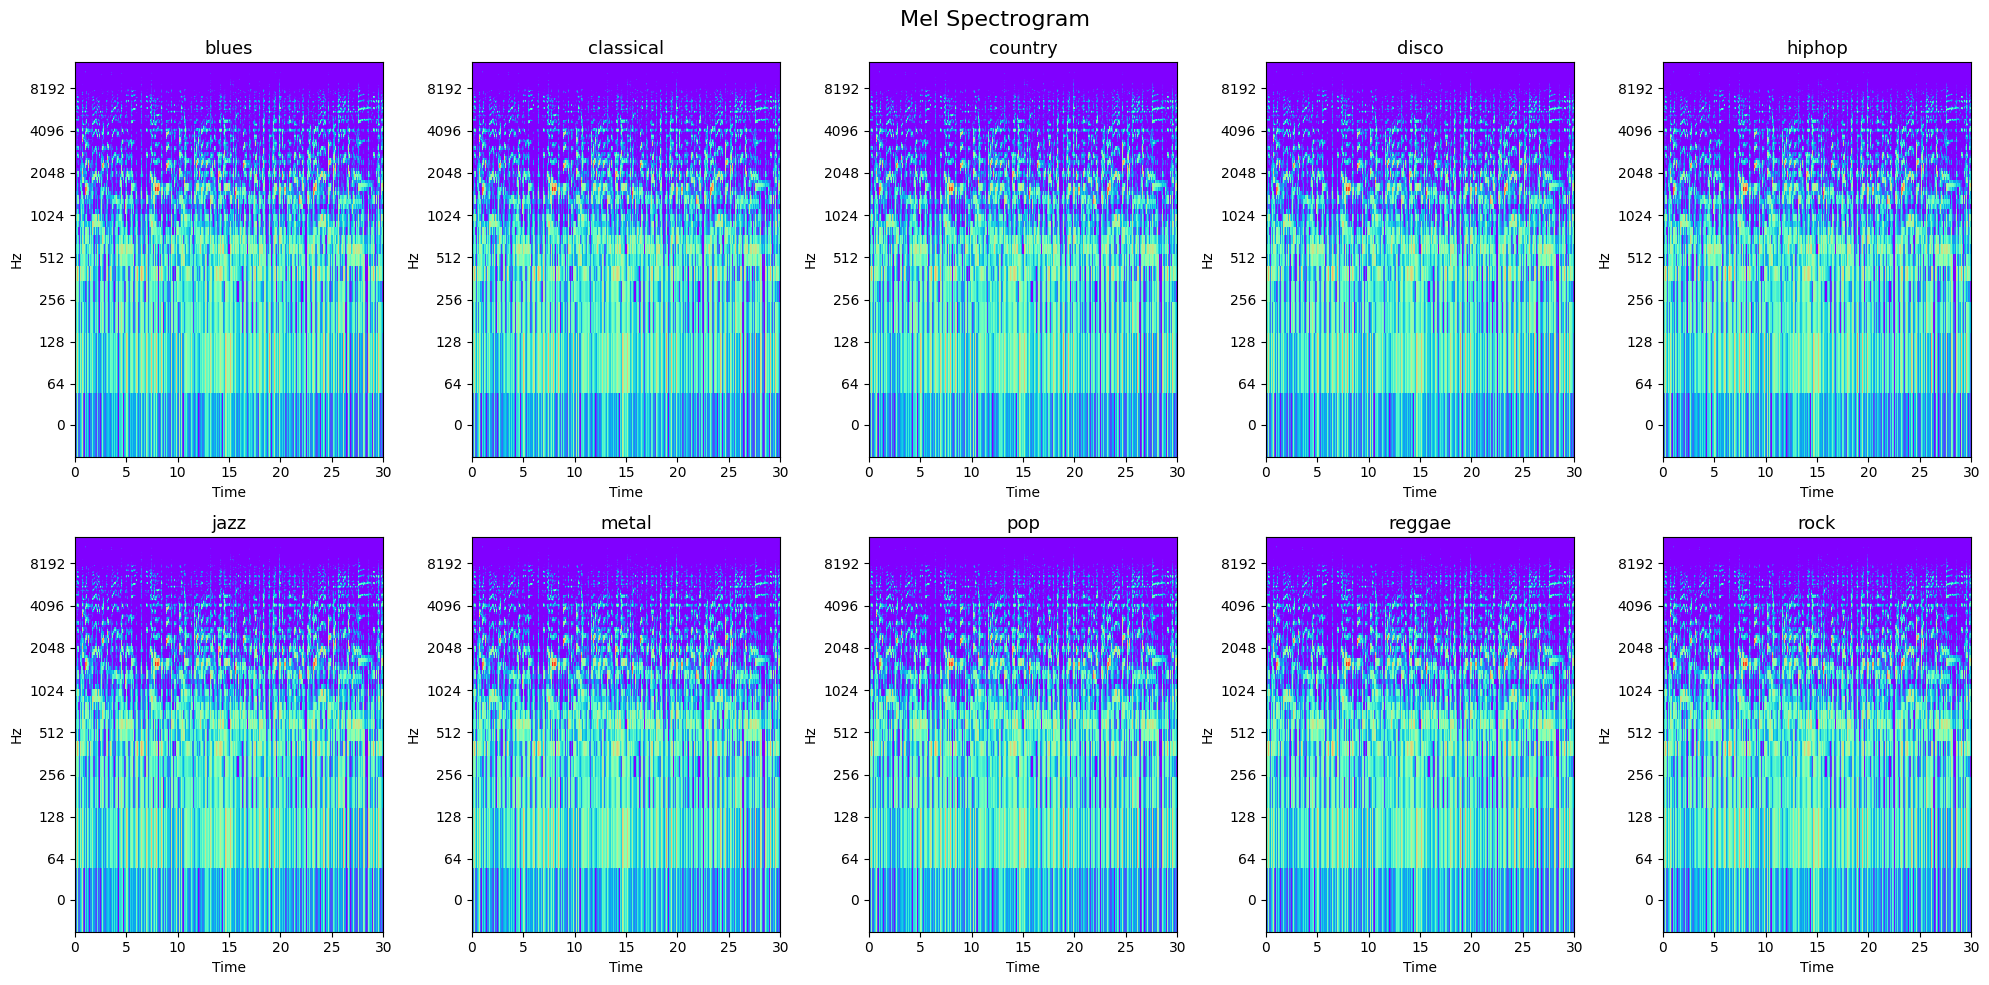

In [55]:
# Mel Spectograms
data = []
hop_length = 512 
ename = list(signals.keys())
for i in fnames:
    y_data, sr_data = librosa.load(fnames[0], sr=25000)  # sr을 명시적으로 지정
    data.append(y_data)

fig, ax = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Mel Spectrogram', fontsize=16)

for i in range(10):
    c = librosa.feature.melspectrogram(y=data[i], sr=25000)  # y와 sr을 명시적으로 지정
    S = librosa.amplitude_to_db(c, ref=np.max)
    row = i // 5
    col = i % 5
    librosa.display.specshow(S, sr=25000, hop_length=hop_length, x_axis='time', 
                             y_axis='log', cmap='rainbow', ax=ax[row, col])
    ax[row, col].set_title(ename[i], fontsize=13)

plt.tight_layout()
plt.show()


In [56]:
# mfcc Extractor

def Feature_extractor(file):
    
    audio,sample_rate=librosa.load(file_name,res_type='kaiser_fast')
    mfccs_features=librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
    mfccs_scaled_features =np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [57]:
extracted_features=[]

for index_num,row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath('C:/jenre/GTZAN/'),str(row["FileName"]))
    final_class_label=row["Class"]
    data=Feature_extractor(file_name)
    extracted_features.append([data,final_class_label])

999it [00:35, 28.39it/s]


In [58]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['features','class'])
extracted_features_df.head(20)

,features,class
0,"[-113.59882, 121.57067, -19.162262, 42.363937,...",blues
1,"[-207.52383, 123.98514, 8.947019, 35.86715, 2....",blues
2,"[-90.757164, 140.44087, -29.084547, 31.686693,...",blues
3,"[-199.57513, 150.0861, 5.663404, 26.855282, 1....",blues
4,"[-160.35417, 126.20948, -35.581394, 22.139256,...",blues
5,"[-177.80176, 118.20316, -17.57063, 30.760927, ...",blues
6,"[-190.0688, 130.27023, -36.362114, 33.03621, 1...",blues
7,"[-179.3723, 136.44833, -26.662588, 39.96545, 5...",blues
8,"[-121.38979, 122.49833, -14.734729, 46.122135,...",blues
9,"[-213.26424, 115.16476, -11.69817, 39.015358, ...",blues


In [59]:
# from sklearn.preprocessing import LabelEncoder
X=np.array(extracted_features_df['features'].tolist())
y=np.array(extracted_features_df["class"].tolist())

In [60]:
X.shape

(999, 40)

In [61]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()
y=to_categorical(LE.fit_transform(y))

In [62]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [63]:
print("Shape Of X_train:",X_train.shape)
print("Shape Of X_test:",X_test.shape)
print("Shape Of y_train:",y_train.shape)
print("Shape Of y_test:",y_test.shape)

Shape Of X_train: (799, 40)
Shape Of X_test: (200, 40)
Shape Of y_train: (799, 10)
Shape Of y_test: (200, 10)


In [64]:
# Setting labels
num_labels=y.shape[1]

In [65]:
# Creating Our Model

model=Sequential()
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [66]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 100)               4100      
                                                                 
 activation_5 (Activation)   (None, 100)               0         
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 200)               20200     
                                                                 
 activation_6 (Activation)   (None, 200)               0         
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_7 (Dense)             (None, 200)              

In [67]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [68]:
from tensorflow.keras.callbacks import ModelCheckpoint
# tf.keras.callbacks.ModelCheckpoint
from datetime import datetime

num_epochs=100
num_batch_size=32

checkpointer=ModelCheckpoint(filepath='saved_models/audio_classification.hdf5',verbose=1,save_best_only=True)
start=datetime.now()
history = model.fit(X_train,y_train,batch_size=num_batch_size,epochs=num_epochs,validation_data=(X_test,y_test),callbacks=checkpointer)

duration=datetime.now()-start
print("Training Completed in time: ",duration)

Epoch 1/100
12/25 [=============>................] - ETA: 0s - loss: 14.6912 - accuracy: 0.1120 
Epoch 1: val_loss improved from inf to 2.31310, saving model to saved_models\audio_classification.hdf5
25/25 [==============================] - 1s 11ms/step - loss: 10.6696 - accuracy: 0.1252 - val_loss: 2.3131 - val_accuracy: 0.1650
Epoch 2/100
20/25 [=======================>......] - ETA: 0s - loss: 4.2265 - accuracy: 0.1281
Epoch 2: val_loss improved from 2.31310 to 2.21214, saving model to saved_models\audio_classification.hdf5


C:\Users\sanjuk\anaconda3\envs\Sample2\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 0s 7ms/step - loss: 4.0728 - accuracy: 0.1327 - val_loss: 2.2121 - val_accuracy: 0.2450
Epoch 3/100
21/25 [========================>.....] - ETA: 0s - loss: 2.8181 - accuracy: 0.1637
Epoch 3: val_loss improved from 2.21214 to 2.18515, saving model to saved_models\audio_classification.hdf5
25/25 [==============================] - 0s 11ms/step - loss: 2.8008 - accuracy: 0.1615 - val_loss: 2.1852 - val_accuracy: 0.2400
Epoch 4/100
22/25 [=========================>....] - ETA: 0s - loss: 2.6231 - accuracy: 0.1690
Epoch 4: val_loss improved from 2.18515 to 2.18355, saving model to saved_models\audio_classification.hdf5
25/25 [==============================] - 0s 11ms/step - loss: 2.5724 - accuracy: 0.1752 - val_loss: 2.1835 - val_accuracy: 0.2450
Epoch 5/100
22/25 [=========================>....] - ETA: 0s - loss: 2.4347 - accuracy: 0.1705
Epoch 5: val_loss improved from 2.18355 to 2.17287, saving model to saved_models\audio_classification.hdf5
25/25

In [69]:
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

7/7 [==============================] - 0s 3ms/step


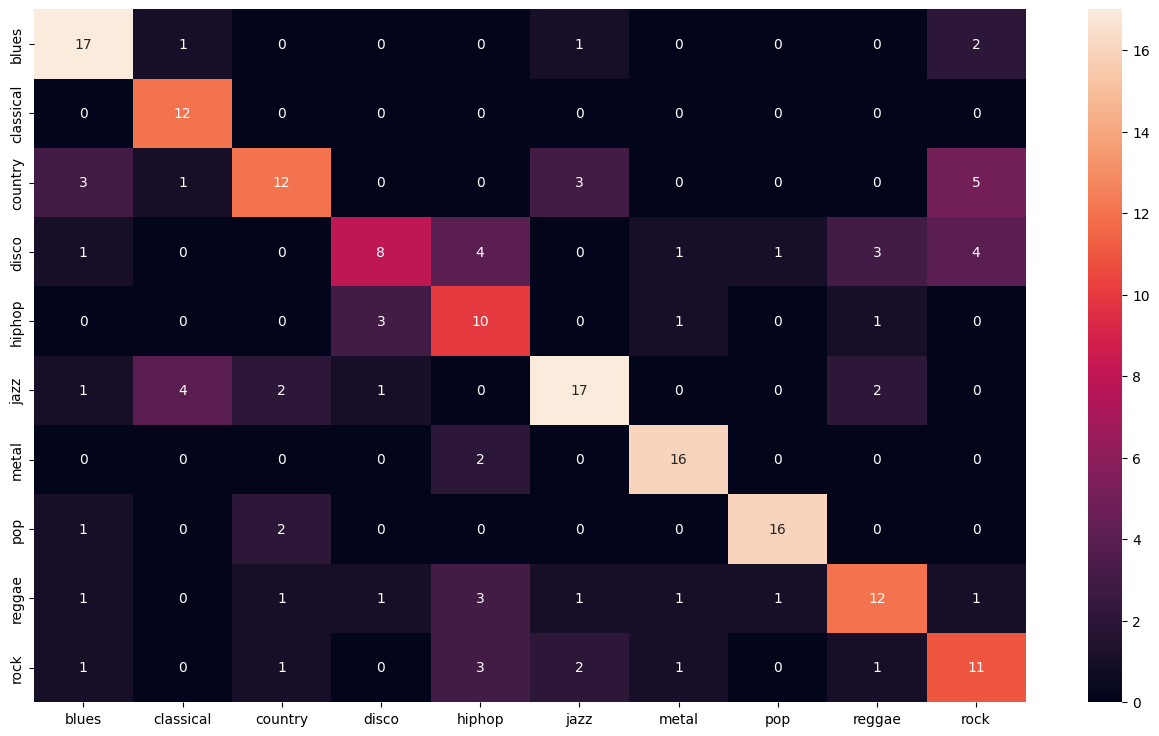

In [79]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(16,9))
sns.heatmap(
    cm,
    annot=True,
    xticklabels=["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"],
    yticklabels=["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]
)
plt.show()

In [71]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_accuracy vs val_accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

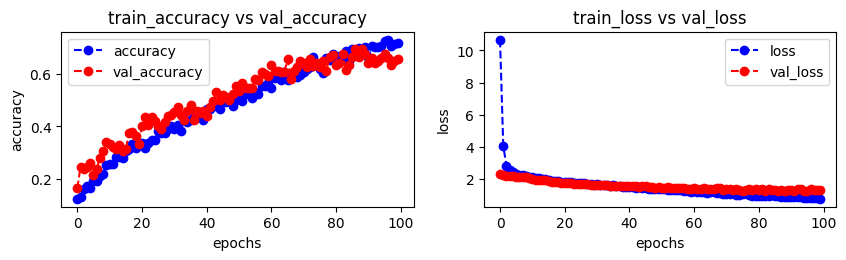

In [72]:
plot_accuracy_loss(history)

In [73]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.6549999713897705


In [74]:
import os
import random
import IPython.display as ipd 

# 폴더 경로 설정
folder_path = "C:\\Capstone\\GTZAN_data\\"

# 폴더 내 파일 목록 가져오기
file_names = os.listdir(folder_path)

# 랜덤으로 파일 선택
random_file_name = random.choice(file_names)
file_path = os.path.join(folder_path, random_file_name)

# 오디오 파일 로드 및 테스트
audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
mfccs_scaled_features = mfccs_scaled_features.reshape(1, -1)

# 모델 예측
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
prediction_class = LE.inverse_transform(predicted_label)

# 결과 출력
print("파일 이름:", random_file_name)
print("예측된 클래스:", prediction_class)

# 오디오 재생
ipd.Audio(file_path)


FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'C:\\Capstone\\GTZAN_data\\'

In [75]:
# Testing an audio from test set

filename="C:/Users/sanjuk/Desktop/foryou.wav"
audio,sample_rate=librosa.load(filename,res_type='kaiser_fast')
mfccs_features=librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
mfccs_scaled_features =np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)

predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print(predicted_label)

prediction_class=LE.inverse_transform(predicted_label)
prediction_class

[-142.66612      76.30468     -19.94641      39.691757     -6.963554
   21.280882    -11.160109     15.993395    -15.2783985     9.022909
  -10.714843      5.1121655    -9.241176      5.300358    -10.940944
    3.178562    -11.707394      1.9358103   -10.478815      1.4511776
   -6.574233      0.7131083    -4.9923882     2.515456     -3.669078
    2.3890998    -1.4228165     1.3506309    -3.973115      0.47077364
   -1.1927676     1.4007858    -1.1107718    -0.4069736    -2.0447996
    0.5804425    -0.49574485   -0.4673865    -1.8767172    -0.5805759 ]
[[-142.66612      76.30468     -19.94641      39.691757     -6.963554
    21.280882    -11.160109     15.993395    -15.2783985     9.022909
   -10.714843      5.1121655    -9.241176      5.300358    -10.940944
     3.178562    -11.707394      1.9358103   -10.478815      1.4511776
    -6.574233      0.7131083    -4.9923882     2.515456     -3.669078
     2.3890998    -1.4228165     1.3506309    -3.973115      0.47077364
    -1.1927676    

array(['metal'], dtype='<U9')